In [9]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy
from torchsummary import summary


In [10]:
# Define device for torch
device = torch.device("cpu")
# MPS for Apple Silicon GPUs
if torch.mps.is_available():
   print("MPS is available")
   device = torch.device("mps")

# CUDA for Nvidia GPUs
if torch.cuda.is_available():
   print("CUDA is available")
   device = torch.device("cuda")
print(device)

MPS is available
mps


# Creating Dataset & Dataloader Objects

In [11]:
class HDBDataset(Dataset):
    def __init__(self, csv_path):
        self.dataframe = pd.read_csv(csv_path)
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Extract target from index 3
        target = self.dataframe.iloc[idx, 3]  
        
        # Extract all other columns *except* the target column (drop index 3)
        features = self.dataframe.drop(columns=self.dataframe.columns[3]).iloc[idx].values
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)
        
        return features, target

In [12]:
batch_size = 512

train_dataset = HDBDataset("data/train_data.csv")
test_dataset = HDBDataset("data/test_data.csv")
valid_dataset = HDBDataset("data/valid_data.csv")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle= False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle= False)

# Baseline Model 1 (BM_nn1)

## Creating BM_nn1

In [13]:
class HDBPricePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(52, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.fc = nn.Linear(32, 1)
        self.activation = nn.ReLU()
        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.input(x)
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.fc(x)
        return x

In [18]:
model = HDBPricePredictor().to("cpu") 

# Summarize the model
summary(model, input_size=(52,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           6,784
            Linear-2                   [-1, 64]           8,256
              ReLU-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
            Linear-6                    [-1, 1]              33
Total params: 17,153
Trainable params: 17,153
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


## Training BM_nn1

In [43]:
# Create Neural Network model
model = HDBPricePredictor().to(device)

# Gradient descent parameters: optimizers, repetitions, etc.
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.01,
                           betas=(0.9, 0.999),
                           eps=1e-08,
                           weight_decay=0.00)
optimizer.zero_grad()

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    # Create lists for the epoch's train accuracies
    batch_train_losses = []
    batch_validation_losses = []
    for batch in train_loader:
        # Unpack the mini-batch data
        inputs_batch, outputs_batch = batch
        outputs_re = outputs_batch.to(device).reshape(-1, 1)
        inputs_re = inputs_batch.to(device)
        
        # Forward pass
        pred = model(inputs_re)
        loss_value = model.loss(pred.float(), outputs_re.float())
    
        # Backward pass and optimization
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        batch_train_losses.append(loss_value.item())
    train_losses.append(sum(batch_train_losses)/len(batch_train_losses))
    # Validation loop
    model.eval()
    
    print("Training done! Validation commencing...")
    with torch.no_grad():
        for batch in valid_loader:
            inputs_batch, outputs_batch = batch
            outputs_re = outputs_batch.to(device).reshape(-1, 1)
            inputs_re = inputs_batch.to(device)
            
            pred = model(inputs_re)
            val_loss = model.loss(pred.float(), outputs_re.float())
            
            batch_validation_losses.append(val_loss.item())
        val_losses.append(sum(batch_validation_losses)/len(batch_validation_losses))
    
    print(f'Epoch [{epoch+1}/{num_epochs}]', f'Train Loss: {loss_value.item():.4f}',f'Val Loss: {val_loss.item():.4f}')
    
    # Save the model weights for each epoch
    torch.save(model.state_dict(), f'nn_baseline_weights/model_weights_epoch_{epoch+1}.pth')

Training done! Validation commencing...
Epoch [1/10] Train Loss: 8962294784.0000 Val Loss: 9029208064.0000
Training done! Validation commencing...
Epoch [2/10] Train Loss: 6815178240.0000 Val Loss: 5636640768.0000
Training done! Validation commencing...
Epoch [3/10] Train Loss: 4508201984.0000 Val Loss: 4020889600.0000
Training done! Validation commencing...
Epoch [4/10] Train Loss: 4201929984.0000 Val Loss: 3768000768.0000
Training done! Validation commencing...
Epoch [5/10] Train Loss: 4363765248.0000 Val Loss: 2321892608.0000
Training done! Validation commencing...
Epoch [6/10] Train Loss: 3655617024.0000 Val Loss: 1978969216.0000
Training done! Validation commencing...
Epoch [7/10] Train Loss: 2863943936.0000 Val Loss: 1990138752.0000
Training done! Validation commencing...
Epoch [8/10] Train Loss: 2656025088.0000 Val Loss: 2058622592.0000
Training done! Validation commencing...
Epoch [9/10] Train Loss: 2749596672.0000 Val Loss: 2120203648.0000
Training done! Validation commencing.

## Evaluating BM_nn1

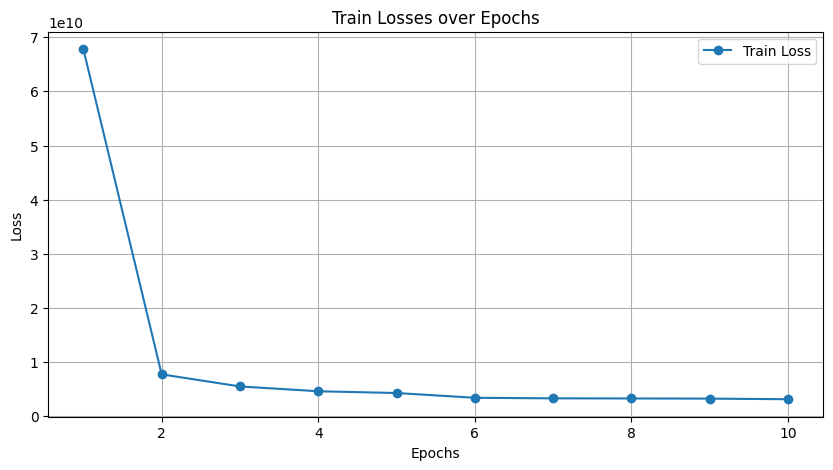

In [49]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.title('Train Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [111]:
# Load the best model weights from the best performing epoch and test them
model = HDBPricePredictor().to(device)
model.load_state_dict(torch.load('nn_baseline_weights/model_weights_epoch_10.pth', weights_only=True))
# Set model to evaluation mode
model.eval()

# Evaluate on test set
test_losses = []

# Initialize L1Loss function
loss_function = nn.L1Loss()

with torch.no_grad():
    for batch in test_loader:
        # Unpack test batch
        inputs_batch, outputs_batch = batch
        outputs_re = outputs_batch.to(device).reshape(-1, 1)
        inputs_re = inputs_batch.to(device)
        
        # Forward pass
        test_pred = model(inputs_re)
        test_loss = loss_function(test_pred.float(), outputs_re.float())
        
        test_losses.append(test_loss.item())

# Calculate average test metrics
avg_test_loss = sum(test_losses) / len(test_losses)

print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 39673.2846


In [112]:
# Select an index (e.g., the first sample)
sample_idx = 3488 # Adjust this number to see the result for different samples
sample_features, sample_target = test_dataset[sample_idx]
sample_features = sample_features.to(device).unsqueeze(0)  # Add batch dimension (1, num_features)
# Set model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    predicted_price = model(sample_features).item()  # Convert tensor to scalar

print(f"Actual Resale Price: {sample_target.item():,.2f}")
print(f"Predicted Resale Price: {predicted_price:,.2f}")


Actual Resale Price: 670,000.00
Predicted Resale Price: 695,856.25


# Baseline Model 2 (BM_nn2)

## Creating BM_nn2

In [19]:
# New model to train

class HDBPricePredictor2(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(52, 256)  # Increased neurons for better feature extraction
        self.hidden1 = nn.Linear(256, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.fc = nn.Linear(64, 1)

        # Activation functions
        self.activation = nn.LeakyReLU(0.01)  # More stable than ReLU

        # Normalization & Dropout
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)

        self.dropout = nn.Dropout(0.1)  # Light dropout

        # Use Huber Loss instead of MSE
        self.loss = nn.SmoothL1Loss()

        # Initialize weights
        self._init_weights()

    def forward(self, x):
        x = self.input(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.hidden1(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.hidden2(x)
        x = self.bn3(x)
        x = self.activation(x)

        x = self.fc(x)
        return x

    def _init_weights(self):
        for layer in [self.input, self.hidden1, self.hidden2, self.fc]:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
            nn.init.constant_(layer.bias, 0)



In [20]:
model = HDBPricePredictor2().to("cpu") 

# Summarize the model
summary(model, input_size=(52,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          13,568
       BatchNorm1d-2                  [-1, 256]             512
         LeakyReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
       BatchNorm1d-5                  [-1, 128]             256
         LeakyReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
       BatchNorm1d-9                   [-1, 64]             128
        LeakyReLU-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 55,681
Trainable params: 55,681
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Training Baseline Model 2

In [83]:
# Create Neural Network model
model = HDBPricePredictor2().to(device)

# Gradient descent parameters: optimizers, repetitions, etc.
num_epochs = 15
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.01,
                           betas=(0.9, 0.999),
                           eps=1e-08,
                           weight_decay=0.001)
optimizer.zero_grad()

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    # Create lists for the epoch's train accuracies
    batch_train_losses = []
    batch_validation_losses = []
    for batch in train_loader:
        # Unpack the mini-batch data
        inputs_batch, outputs_batch = batch
        outputs_re = outputs_batch.to(device).reshape(-1, 1)
        inputs_re = inputs_batch.to(device)
        
        # Forward pass
        pred = model(inputs_re)
        loss_value = model.loss(pred.float(), outputs_re.float())
    
        # Backward pass and optimization
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        batch_train_losses.append(loss_value.item())
    train_losses.append(sum(batch_train_losses)/len(batch_train_losses))
    # Validation loop
    model.eval()
    
    print("Training done! Validation commencing...")
    with torch.no_grad():
        for batch in valid_loader:
            inputs_batch, outputs_batch = batch
            outputs_re = outputs_batch.to(device).reshape(-1, 1)
            inputs_re = inputs_batch.to(device)
            
            pred = model(inputs_re)
            val_loss = model.loss(pred.float(), outputs_re.float())
            
            batch_validation_losses.append(val_loss.item())
        val_losses.append(sum(batch_validation_losses)/len(batch_validation_losses))
    
    print(f'Epoch [{epoch+1}/{num_epochs}]', f'Train Loss: {loss_value.item():.4f}',f'Val Loss: {val_loss.item():.4f}')
    
    # Save the model weights for each epoch
    torch.save(model.state_dict(), f'nn_baseline_weights/model2_weights_epoch_{epoch+1}.pth')

Training done! Validation commencing...
Epoch [1/15] Train Loss: 514146.7812 Val Loss: 527485.5625
Training done! Validation commencing...
Epoch [2/15] Train Loss: 506218.6562 Val Loss: 521849.6250
Training done! Validation commencing...
Epoch [3/15] Train Loss: 488634.5938 Val Loss: 512848.5938
Training done! Validation commencing...
Epoch [4/15] Train Loss: 469675.8750 Val Loss: 500550.6875
Training done! Validation commencing...
Epoch [5/15] Train Loss: 468285.0312 Val Loss: 485607.0625
Training done! Validation commencing...
Epoch [6/15] Train Loss: 449790.5000 Val Loss: 468632.2812
Training done! Validation commencing...
Epoch [7/15] Train Loss: 441892.2812 Val Loss: 448612.6875
Training done! Validation commencing...
Epoch [8/15] Train Loss: 427641.9688 Val Loss: 426918.3750
Training done! Validation commencing...
Epoch [9/15] Train Loss: 382074.6875 Val Loss: 402831.5312
Training done! Validation commencing...
Epoch [10/15] Train Loss: 393552.6250 Val Loss: 376463.5000
Training 

## Evaluating BM_nn2

In [114]:
# Load the best model weights from the best performing epoch and test them
model = HDBPricePredictor2().to(device)
model.load_state_dict(torch.load('nn_baseline_weights/model2_weights_epoch_15.pth', weights_only=True))
# Set model to evaluation mode
model.eval()

# Evaluate on test set
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        # Unpack test batch
        inputs_batch, outputs_batch = batch
        outputs_re = outputs_batch.to(device).reshape(-1, 1)
        inputs_re = inputs_batch.to(device)
        
        # Forward pass
        test_pred = model(inputs_re)
        test_loss = model.loss(test_pred.float(), outputs_re.float())
        
        test_losses.append(test_loss.item())

# Calculate average test metrics
avg_test_loss = sum(test_losses) / len(test_losses)

print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 220175.0961


In [115]:
# Select an index (e.g., the first sample)
sample_idx = 380 # Adjust this number to see the result for different samples
sample_features, sample_target = test_dataset[sample_idx]
sample_features = sample_features.to(device).unsqueeze(0)  # Add batch dimension (1, num_features)
# Set model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    predicted_price = model(sample_features).item()  # Convert tensor to scalar

print(f"Actual Resale Price: {sample_target.item():,.2f}")
print(f"Predicted Resale Price: {predicted_price:,.2f}")


Actual Resale Price: 875,000.00
Predicted Resale Price: 255,628.47


# Baseline Model 3 (BM_nn3)

## Creating BM_nn3

In [118]:
# New model to train

class HDBPricePredictor3(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(52, 512)  # Increased neurons for better feature extraction
        self.hidden0 = nn.Linear(512,256)
        self.hidden1 = nn.Linear(256, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.fc = nn.Linear(64, 1)

        # Activation functions
        self.activation = nn.LeakyReLU(0.01)  # More stable than ReLU

        # Normalization & Dropout
        self.bn0 = nn.BatchNorm1d(512)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)

        self.dropout = nn.Dropout(0.05)  # Light dropout

        # Use Huber Loss instead of MSE
        self.loss = nn.MSELoss()

        # Initialize weights
        self._init_weights()

    def forward(self, x):
        x = self.input(x)

        x = self.hidden0(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.hidden1(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.hidden2(x)
        x = self.bn3(x)
        x = self.activation(x)

        x = self.fc(x)
        return x

    def _init_weights(self):
        for layer in [self.input, self.hidden1, self.hidden2, self.fc]:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
            nn.init.constant_(layer.bias, 0)


## Training BM_nn3

In [119]:
# Create Neural Network model
model = HDBPricePredictor3().to(device)

# Gradient descent parameters: optimizers, repetitions, etc.
num_epochs = 15
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.005,
                           betas=(0.9, 0.999),
                           eps=1e-08,
                           weight_decay=0.001)
optimizer.zero_grad()

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    # Create lists for the epoch's train accuracies
    batch_train_losses = []
    batch_validation_losses = []
    for batch in train_loader:
        # Unpack the mini-batch data
        inputs_batch, outputs_batch = batch
        outputs_re = outputs_batch.to(device).reshape(-1, 1)
        inputs_re = inputs_batch.to(device)
        
        # Forward pass
        pred = model(inputs_re)
        loss_value = model.loss(pred.float(), outputs_re.float())
    
        # Backward pass and optimization
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        batch_train_losses.append(loss_value.item())
    train_losses.append(sum(batch_train_losses)/len(batch_train_losses))
    # Validation loop
    model.eval()
    
    print("Training done! Validation commencing...")
    with torch.no_grad():
        for batch in valid_loader:
            inputs_batch, outputs_batch = batch
            outputs_re = outputs_batch.to(device).reshape(-1, 1)
            inputs_re = inputs_batch.to(device)
            
            pred = model(inputs_re)
            val_loss = model.loss(pred.float(), outputs_re.float())
            
            batch_validation_losses.append(val_loss.item())
        val_losses.append(sum(batch_validation_losses)/len(batch_validation_losses))
    
    print(f'Epoch [{epoch+1}/{num_epochs}]', f'Train Loss: {loss_value.item():.4f}',f'Val Loss: {val_loss.item():.4f}')
    
    # Save the model weights for each epoch
    torch.save(model.state_dict(), f'nn_baseline_weights/model3_weights_epoch_{epoch+1}.pth')

Training done! Validation commencing...
Epoch [1/15] Train Loss: 291567763456.0000 Val Loss: 316220833792.0000
Training done! Validation commencing...
Epoch [2/15] Train Loss: 290183184384.0000 Val Loss: 314332905472.0000
Training done! Validation commencing...
Epoch [3/15] Train Loss: 279852744704.0000 Val Loss: 311458922496.0000
Training done! Validation commencing...
Epoch [4/15] Train Loss: 294081626112.0000 Val Loss: 307252854784.0000
Training done! Validation commencing...
Epoch [5/15] Train Loss: 290839658496.0000 Val Loss: 302610841600.0000
Training done! Validation commencing...
Epoch [6/15] Train Loss: 298546036736.0000 Val Loss: 295791001600.0000
Training done! Validation commencing...
Epoch [7/15] Train Loss: 274783191040.0000 Val Loss: 289568292864.0000
Training done! Validation commencing...
Epoch [8/15] Train Loss: 272861347840.0000 Val Loss: 278879436800.0000
Training done! Validation commencing...
Epoch [9/15] Train Loss: 262987694080.0000 Val Loss: 275861798912.0000
T

## Evaluating BM_nn3

In [102]:
# Load the best model weights from the best performing epoch and test them
model = HDBPricePredictor3().to(device)
model.load_state_dict(torch.load('nn_baseline_weights/model3_weights_epoch_7.pth', weights_only=True))
# Set model to evaluation mode
model.eval()

# Evaluate on test set
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        # Unpack test batch
        inputs_batch, outputs_batch = batch
        outputs_re = outputs_batch.to(device).reshape(-1, 1)
        inputs_re = inputs_batch.to(device)
        
        # Forward pass
        test_pred = model(inputs_re)
        test_loss = model.loss(test_pred.float(), outputs_re.float())
        
        test_losses.append(test_loss.item())

# Calculate average test metrics
avg_test_loss = sum(test_losses) / len(test_losses)

print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 204991929548.8000


In [103]:
# Select an index (e.g., the first sample)
sample_idx = 397 # Adjust this number to see the result for different samples
sample_features, sample_target = test_dataset[sample_idx]
sample_features = sample_features.to(device).unsqueeze(0)  # Add batch dimension (1, num_features)
# Set model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    predicted_price = model(sample_features).item()  # Convert tensor to scalar

print(f"Actual Resale Price: {sample_target.item():,.2f}")
print(f"Predicted Resale Price: {predicted_price:,.2f}")

Actual Resale Price: 360,000.00
Predicted Resale Price: -367.67
